In [96]:
from google.colab import drive
drive.mount('/content/drive')
import torch
import random
import numpy as np
from matplotlib import pyplot as plt
import torchvision
plt.show()
import scipy.io as sio
from torch.utils.data import Dataset, DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# # test = sio.loadmat("drive/My Drive/Colab Notebooks/cv202/assignment 8/test_32x32.mat" )
# a=sio.loadmat("drive/My Drive/Colab Notebooks/PeaksData.mat" )


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [97]:
import scipy.io
import math
import numpy as np
import random
import matplotlib.pyplot as plt

In [98]:
# Auxiliary functions 
def carryLeftArg(fu, b, c):
    return lambda a: fu(a,b,c)

def carryMiddleArg(fu, a, c):
    return lambda b: fu(a,b,c)

def carryLeftAndMiddleArgs(fu, c):
    return lambda a,b: fu(a,b,c)

# vectorized functions
vec_exp = np.vectorize(math.exp)
vec_identity = np.vectorize(lambda a : a)
vec_tanh_derivative = np.vectorize(lambda a : 1-(math.tanh(a)**2))

# matrix manipulation functions
def pertVecMatrix(M, vec, ind): # Adds a vector to column ind of M
    M = M.copy() # So M itself won't change.
    M[:, ind] = M[:, ind] + vec
    return M

def sumWeirdMat(W):
    s = 0
    for i in range(W.shape[0]):
        s += sumMat(W[i])
    return s

def sumMat(M):
    if M.dtype == 'O': return sumWeirdMat(M)
    s = M
    for i in range(len(M.shape)):
        s = sum(s)
    return s

def sampleData(X, C, batch_size):
    indecies = [random.randint(0, X.shape[1]-1) for i in range(batch_size)]
    X_batch = np.array([X[:,i] for i in indecies])
    C_batch = np.array([C[:,i] for i in indecies])
    return X_batch.T, C_batch.T

def sum_of_outer_products(A, B):
    output = np.zeros((A.shape[0], B.shape[0]))
    for i in range(A.shape[1]):
        output += np.outer(A[:,i], B[:,i])
    return output

Read the data and initilize the weights matrix

In [99]:
# Extract the data
mat = sio.loadmat("drive/My Drive/Colab Notebooks/PeaksData.mat" )
dataset_name = 'PeaksData'

Ct=mat.get('Ct') # 5 by 25000 matrix - l by m
Cv=mat.get('Cv')
Xt=mat.get('Yt') # 2 by 25000 matrix - n by m (3 by 25000 after adding a row of ones for the bias interactions)
Xv=mat.get('Yv')
# n features, m size of training sample, l labels
n = Xt.shape[0]
l = Ct.shape[0]
m = Ct.shape[1]

In [100]:
# initialize W and add ones row to X for the biases
def initialW(n,l):
    W = np.random.rand(n,l)
    return W

def add_b(X):
    m = X.shape[1]
    ones_vector = np.ones(shape=(1,m))
    X = np.concatenate((X, ones_vector), axis=0)
    return X

Define the softmax and the softmaxLoss

In [101]:
def softmax(X, W):
    out = np.matmul(add_b(X).transpose(), W)
    eta = out.max()
    out = out - eta
    out = vec_exp(out)
    sum_of_elements = np.array([sum(row) for row in out])
    for i in range(out.shape[0]):
        out[i] = out[i] / sum_of_elements[i]
    return out

In [102]:
def softmaxLoss(X, W, C):
    Cn = [C[:,i].tolist().index(1) for i in range(C.shape[1])]
    softmax_matrix = softmax(X,W)
    loss = 0
    for i in range(len(Cn)):
        loss = loss + math.log(softmax_matrix[i][Cn[i]])
    return -loss/len(Cn)

In [103]:
def softmaxClassifier(X,W):
    M = softmax(X,W).T
    preds = np.empty(M.shape[1])
    for i in range(preds.size):
        preds[i] = M[:,i].argmax()
    return preds

In [104]:
def computeSucRate(X, C, W, classifier):
    subsample_size = 750
    X_sample, C_sample = sampleData(X, C, subsample_size)
    preds = classifier(X_sample, W)
    return sum(np.array([preds[i]==C_sample[:,i].argmax() for i in range(subsample_size)]))/subsample_size

Define the derivatives of the softmax loss function according to X and according to W

In [105]:
# gradients of the loss of the softmax with relation to W.
def dLoss_dW(X,W,C):
    smXW = softmax(X, W)
    return np.matmul(add_b(X), smXW-C.T) /X.shape[1]

In [106]:
# gradients of the loss of the softmax with relation to X
def dLoss_dX(X,W,C):
    smXW = softmax(X, W)
    return (np.delete(np.matmul(W, smXW.T - C)/X.shape[1], X.shape[0], 0))

define the grad_test function

In [107]:
def ratiosConvergenceTest(vec, ratio, epsilon):
    counter = 0
    for i in range(vec.size-1):
        if (abs(vec[i]/vec[i+1])<=ratio + epsilon and
            abs(vec[i]/vec[i+1])>=ratio - epsilon):
                counter = counter+1
    return counter >=3

In [108]:
# fun_to_grad: nparr --> grad (takes a point in the domain and returns it's gradient)
# fun_to_f_arr: nparr --> f(nparr) (f is scalar. takes a point in the domain and returns a number)
# we assume dims(nparr) = dims(grad) (so to get 
#the change in output from the change in input multiply the
# change in input entry-entry with the gradient and sum
# - like scalar product) 
def gradTest(fun_to_f_arr, fun_to_grad, nparr):
    times = 15 # Number of sampeling points.
    grad = fun_to_grad(nparr)
    n = grad.shape[0]
    fx = fun_to_f_arr(nparr) 
    A = np.random.rand(*grad.shape)
    A = A/sumMat(A)
    d_grad = sumMat(A*grad) 
    fx_epsilon = (np.array([fun_to_f_arr(nparr+(2**(-i))*A)
                            for i in range(times)]))
    d_grad_vec = np.array([2**(-i) for i in range(times)]) * d_grad
    df = abs(fx_epsilon-fx)
    df_grad = abs(fx_epsilon - fx - d_grad_vec)
    return df, df_grad

In [109]:
def showTable(df,df_grad, title_str="", layers_dimensions=None):
    arr1 = np.array([df[i]/df[i+1] for i in range(df.size-1)])
    arr2 = np.array([df_grad[i]/df_grad[i+1] for i in range(df.size-1)])
    
    fig, ax = plt.subplots()
    ax.plot(df, label=r'df (i) = $|f(x+{\varepsilon}_{i}d)-f(x)|$')
    ax.plot(df_grad, label=r'df_grad (i) = $|f(x+\varepsilon_{i}d)−f(x)-\varepsilon_{i}d^T\nabla(x)| $')
    ax.plot(arr1, label=r'df (i) / df (i+1)')
    ax.plot(arr2, label=r'df_grad (i) / df_grad (i+1)')
    plt.xlabel(r'$-log_2(\varepsilon_i)$')
    plt.ylabel("rate")
    
    if layers_dimensions is None:
        ax.set_title('Grad. Test'+title_str)
    else:
        ax.set_title('Grad. Test'+title_str+r' layers dimensions: '+str(layers_dimensions))
    plt.legend()
    plt.show()

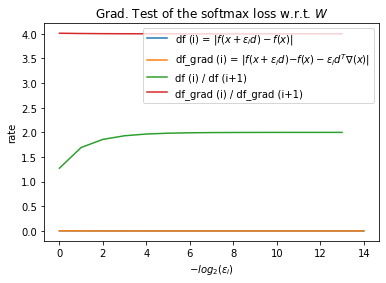

In [110]:
# gradient test to dLoss_dW
X_batch, C_batch = sampleData(Xt, Ct, 2500)
df, df_grad=gradTest(carryMiddleArg(softmaxLoss, X_batch, C_batch),
                     carryMiddleArg(dLoss_dW, X_batch, C_batch),
                     initialW(n+1,l))
showTable(df,df_grad, r' of the softmax loss w.r.t. $W$')

### Second step of part 1: SGD

In [111]:
def gradientDecent(X, W, C, compute_grad, epochs,
                   learning_rate, batch_size, update_epoch_func):
    for i in range(epochs):
        X_batch, C_batch = sampleData(X, C, batch_size)
        W -= learning_rate * compute_grad(X_batch, W, C_batch)
        update_epoch_func(W, iter_num=i)

In [112]:
def plotSucRates(train_suc_rate,valid_suc_rate,loss_rate, epochs,
                 num_of_epochs_groups,ler_rate,batch_size,
                 dataset_name=None, layers_dimensions=None):
    group_epochs = epochs/num_of_epochs_groups
    y= (np.arange(len(train_suc_rate))+1)*group_epochs
    fig, ax = plt.subplots()
    ax.plot(y,train_suc_rate, label="train")
    ax.plot(y,valid_suc_rate, label="validation")
    ax.plot(y,loss_rate, label="loss rate")
    title = "Rates: ler. rate = {}, batch size = {}".format(ler_rate,batch_size)
    if layers_dimensions is not None:
        title += ', dims= '+str(layers_dimensions)
    if dataset_name is not None:
        title += ', dataset= '+dataset_name
    ax.set_title(title)
    
    
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel("numerical value")
    plt.show()

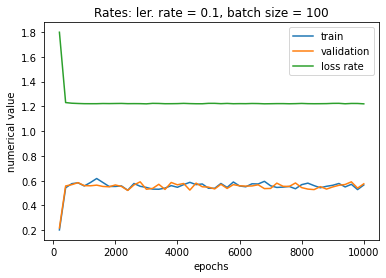

last 5 trains = 0.5581333333333334
last 5 validations = 0.5674666666666667
last 5 loss_rate = 1.222044667976515



In [113]:
epochs = 2000
num_of_epochs_groups = 50
for ler_rate in [1,0.1,0.01,0.001]:
    for batch_size in [1,25,50,100]:
        if ler_rate==1 and batch_size!=100:
            continue
        elif ler_rate == 1:
            epochs = 1000
        elif ler_rate ==0.1:
            epochs = 10000
        elif ler_rate ==0.01:
            epochs = 2500
        elif ler_rate ==0.001:
            if batch_size<25:
                epochs = 15000
            elif batch_size == 25:
                epochs = 25000
            elif batch_size == 50:
                epochs = 20000
            elif batch_size == 100:
                epochs = 18000
            else:
                epochs = 1000
        
        group_epochs = epochs/num_of_epochs_groups
        
        train_suc_rate = np.empty(int(epochs/group_epochs))
        valid_suc_rate = np.empty(int(epochs/group_epochs))
        loss_rate = np.empty(int(epochs/group_epochs))
        
        def updateEpochRates(W, iter_num):
            if iter_num%group_epochs == 0:
                train_suc_rate[int(iter_num/group_epochs)] = computeSucRate(
                    Xt, Ct, W, softmaxClassifier
                )
                valid_suc_rate[int(iter_num/group_epochs)] = computeSucRate(
                    Xv, Cv, W, softmaxClassifier
                )
                loss_rate[int(iter_num/group_epochs)] = softmaxLoss(Xv,W,Cv)
            return
        gradientDecent(Xt, initialW(n+1,l), Ct, compute_grad=dLoss_dW,
                       epochs=epochs, learning_rate=ler_rate,
                       batch_size=batch_size, 
                       update_epoch_func=updateEpochRates)
        
        plotSucRates(train_suc_rate, valid_suc_rate, loss_rate, epochs,
                 num_of_epochs_groups, ler_rate, batch_size)
        
        print("last 5 trains = {}".format(sum(train_suc_rate[-5:])/5))
        print("last 5 validations = {}".format(sum(valid_suc_rate[-5:])/5))
        print("last 5 loss_rate = {}".format(sum(loss_rate[-5:])/5))
        print("")

### Step 1 of part 2

Network definition and forward pass

In [114]:
def defineNetworkParameters(layers_dimensions):
    parameters = [initialW(layers_dimensions[i+1],layers_dimensions[i]+1) for i in range(len(layers_dimensions)-1)] # +1 for the bias
    parameters.append(0)
    #???
    parameters = np.array(parameters)
    return np.delete(parameters, parameters.shape[0]-1, 0)
    
def activationFunctionArray(activation_function, number_of_layers):
    return [activation_function for i in range(number_of_layers-1)]

# defining the net
layers_dimensions = [Xv.shape[0], 5, 10, Cv.shape[0]]
layers_parameters = defineNetworkParameters(layers_dimensions)
layers_activation_functions = activationFunctionArray(np.vectorize(math.tanh), len(layers_dimensions)-1)
af_derivatives = activationFunctionArray(vec_tanh_derivative, len(layers_dimensions)-1)
L = len(layers_dimensions)-1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """


In [115]:
# Define the forward pass
def forwardPass(X, P_array, AF_array):
    layers_neurons = [X]
    for i in range(len(P_array)-1):
        layers_neurons.append(AF_array[i](np.matmul(P_array[i], add_b(layers_neurons[i]))))
    return layers_neurons

Finding the gradients of a layer in the NN with respect to X and with respect to W.

In [116]:
def dX_times_vec(V, X, W, sigma_tag):
    return np.delete(np.matmul(W.T, sigma_tag(np.matmul(W,add_b(X)))*V), W.T.shape[0]-1, 0)

In [117]:
def dW_times_vec(V, X, W, sigma_tag):
    return sum_of_outer_products(sigma_tag(np.matmul(W,add_b(X)))*V, add_b(X))

Performinf the direct Jacobian transpose test to the functions defined above.

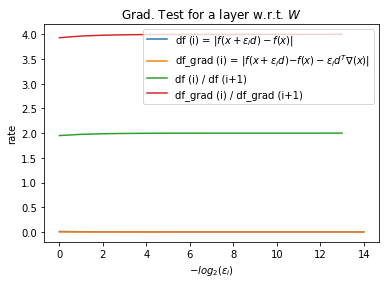

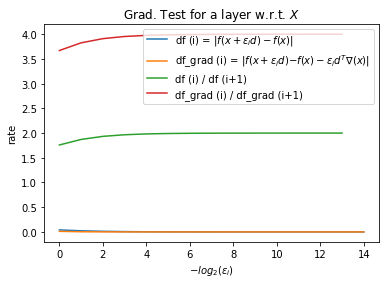

In [118]:
# testing dX_times_vec and dW_times_vec
# define the parameters and the function
a, b = 10, 12
W = initialW(a,b)
X = initialW(b-1,2)
f_of_X = lambda X : np.vectorize(math.tanh)(np.matmul(W, add_b(X)))
f_of_W_and_b = lambda W : np.vectorize(math.tanh)(np.matmul(W, add_b(X)))
sigma_tag = vec_tanh_derivative

u = np.random.rand(W.shape[0], X.shape[1]) 
g_of_X = lambda X : sumMat(u*f_of_X(X))
g_of_W_and_b = lambda W : sumMat(u*f_of_W_and_b(W))

g_of_X_grad = lambda X : dX_times_vec(u,X,W, sigma_tag) # takes X and reurns the gradient of g_of_X at X
g_of_W_and_b_grad = lambda W : dW_times_vec(u,X,W, sigma_tag) # takes W and reurns the gradient of g_of_W_and_b at X

df, df_grad = gradTest(g_of_W_and_b, g_of_W_and_b_grad, W)
showTable(df,df_grad, r' for a layer w.r.t. $W$')

df, df_grad = gradTest(g_of_X, g_of_X_grad, X)
showTable(df,df_grad, r' for a layer w.r.t. $X$')

Back propagation

In [119]:
def backProp(layers_neurons, layers_parameters, C_batch, af_derivatives):
    L = layers_parameters.shape[0]
    dW = [0]
    dW.append(dLoss_dW(layers_neurons[L-1], layers_parameters[L-1].T, C_batch).T)
    dX = dLoss_dX(layers_neurons[L-1], layers_parameters[L-1].T, C_batch)
    for i in range(L-2, -1, -1):
        dW.append(dW_times_vec(dX, layers_neurons[i], layers_parameters[i], af_derivatives[i]))
        dX = dX_times_vec(dX, layers_neurons[i], layers_parameters[i], af_derivatives[i])
    # from here on it's just formating the output dW so it would be a numpy array
    dW.reverse() 
    dW = np.array(dW)
    return np.delete(dW, dW.shape[0]-1, 0) # getting rid of the zero we added to dW

Grad-test to the derivative of the whole net which is calculated with back-prop.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()


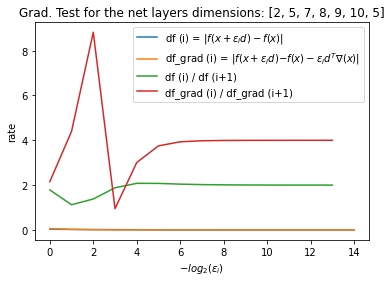

In [120]:
# defining the net
layers_dimensions = [Xv.shape[0], 5,7,8,9,10, Cv.shape[0]]
layers_parameters = defineNetworkParameters(layers_dimensions)
layers_activation_functions = activationFunctionArray(np.vectorize(math.tanh), len(layers_dimensions)-1)
af_derivatives = activationFunctionArray(vec_tanh_derivative, len(layers_dimensions)-1)
L = len(layers_dimensions)-1

# gradient test for the whole net.
X_batch, C_batch = sampleData(Xt, Ct, 100)

# W is a numpy array which holds all the parameters of the net.
W = layers_parameters 
# a function that takes parameters for the net and returns the loss with respect to them
loss_of_W = lambda W : softmaxLoss(forwardPass(X_batch, W, layers_activation_functions)[L-1], W[L-1].T, C_batch)

# a function that takes parameters and returns the gradient with respect to them
compute_W_grad = lambda W : backProp(forwardPass(X_batch, W, layers_activation_functions), W, C_batch, af_derivatives)

df, df_grad = gradTest(loss_of_W, compute_W_grad, W)
showTable(df,df_grad, r' for the net', layers_dimensions)

Training the NN

In [121]:
def computeGradNet(X, W, C):
    return backProp(
        forwardPass(X, W, layers_activation_functions),
        W, C, af_derivatives)

In [122]:
# takes a set of examples and parmeters W for the softmax and returns an array with the predicted labels.
def NNClassifier(X, W, AF_array):
    neurons_layers = forwardPass(X, W, AF_array)
    last_layer_index = W.shape[0]-1
    M = softmax(neurons_layers[last_layer_index],W[last_layer_index].T).T
    preds = np.empty(M.shape[1])
    for i in range(preds.size):
        preds[i] = M[:,i].argmax()
    return preds

In [123]:
def NNLoss(X,C,W, layers_activation_functions):
    L = W.shape[0]
    return softmaxLoss(forwardPass(X, W, layers_activation_functions)[L-1], W[L-1].T, C)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()


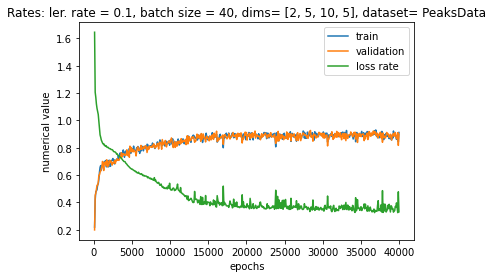

last 5 trains = 0.8802666666666668
last 5 validations = 0.8722666666666667
last 5 smL_rate = 0.37821711815308556



In [124]:
# redefining the net
layers_dimensions = [Xv.shape[0], 5, 10, Cv.shape[0]]
layers_parameters = defineNetworkParameters(layers_dimensions)
layers_activation_functions = activationFunctionArray(np.vectorize(math.tanh), len(layers_dimensions)-1)
af_derivatives = activationFunctionArray(vec_tanh_derivative, len(layers_dimensions)-1)
L = len(layers_dimensions)-1




ler_rate = 0.1
batch_size = 40
epochs = 40000
num_of_epochs_groups = 500

group_epochs = epochs/num_of_epochs_groups

train_suc_rate = np.empty(int(epochs/group_epochs))
valid_suc_rate = np.empty(int(epochs/group_epochs))
loss_rate = np.empty(int(epochs/group_epochs))

def updateEpochRates(W, iter_num):
    if iter_num%group_epochs == 0:
        train_suc_rate[int(iter_num/group_epochs)] = computeSucRate(
            Xt, Ct, W, carryLeftAndMiddleArgs(NNClassifier, layers_activation_functions)
        )
        valid_suc_rate[int(iter_num/group_epochs)] = computeSucRate(
            Xv, Cv, W, carryLeftAndMiddleArgs(NNClassifier, layers_activation_functions)
        )
        loss_rate[int(iter_num/group_epochs)] = NNLoss(Xv,Cv,W, layers_activation_functions)
    return


gradientDecent(Xt, layers_parameters, Ct,
               compute_grad=computeGradNet,
               epochs=epochs,
               learning_rate=ler_rate,
               batch_size=batch_size, 
               update_epoch_func=updateEpochRates)



plotSucRates(train_suc_rate, valid_suc_rate, loss_rate, epochs,
         num_of_epochs_groups, ler_rate, batch_size,
            dataset_name=dataset_name, layers_dimensions=layers_dimensions)

print("last 5 trains = {}".format(sum(train_suc_rate[-5:])/5))
print("last 5 validations = {}".format(sum(valid_suc_rate[-5:])/5))
print("last 5 smL_rate = {}".format(sum(loss_rate[-5:])/5))
print("")